In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks


2025-09-05 14:33:47.376769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757082827.641355      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757082827.722680      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras.applications.xception import preprocess_input

#### Loading data ####

In [3]:
# adding the images, labels, styles
file_path = "/kaggle/input/data-sampling10000-topstyles10/data_sampling10000_topstyles10.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Panayiotis Tetsis,Impressionism,Post-Impressionism,NaN,https://www.wikiart.org/en/panayiotis-tetsis/s...,https://uploads3.wikiart.org/images/panayiotis...,127519-sunset.jpg,['cloudscape'],NaN,NaN
1,Henry Scott Tuke,Impressionism,Impressionism,"['Fun', 'Vacation', 'summer']",https://www.wikiart.org/en/henry-scott-tuke/th...,https://uploads5.wikiart.org/00261/images/henr...,100529-henry-scott-tuke-the-bathers-1922.jpg,['genre painting'],NaN,NaN
2,Alfred Sisley,Impressionism,Impressionism,"['fires-and-floods', 'forests-and-trees', 'Ban...",https://www.wikiart.org/en/alfred-sisley/the-f...,https://uploads1.wikiart.org/images/alfred-sis...,92312-the-flood-on-the-road-to-saint-germain-1...,['landscape'],NaN,NaN
3,Camille Pissarro,Impressionism,Impressionism,"['Grassland', 'Meadow', 'Pasture', 'Plain']",https://www.wikiart.org/en/camille-pissarro/ro...,https://uploads2.wikiart.org/images/camille-pi...,90106-rolling-landscape-in-winter-1875.jpg,['landscape'],NaN,NaN
4,Guy Rose,Impressionism,Impressionism,"['seas-and-oceans', 'cliffs-and-rocks', 'Bank'...",https://www.wikiart.org/en/guy-rose/grey-after...,https://uploads3.wikiart.org/images/guy-rose/g...,104411-grey-afternoon.jpg,['landscape'],NaN,NaN


In [4]:
df.shape

(10000, 10)

In [5]:
list_images= df['file_name'].unique().tolist()

#### Loading and resize images ####

In [6]:
def load_and_resize_images(list_images):

    images_list = []

    for filename in list_images:
            img_path = os.path.join("/kaggle/input/wikiart-all-artpieces/wikiart/wikiart", filename)
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [7]:
images_np = load_and_resize_images(list_images)

#### Define X and y ####

In [8]:
X = images_np

In [9]:
y = df['style']

In [10]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (10000, 224, 224, 3)
y shape: (10000,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

#### Encode labels ####

In [12]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [13]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

In [14]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [15]:
def load_model():
    model = Xception(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model


In [16]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

I0000 00:00:1757082974.250118      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757082974.250810      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)

    # Remplacer Flatten par GlobalAveragePooling2D pour réduire drastiquement les paramètres
    gap = layers.GlobalAveragePooling2D()(base_model.output)

    # Couche dense plus compacte + Dropout
    dense1 = layers.Dense(256, activation='relu')(gap)
    drop1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu')(drop1)
    drop2 = layers.Dropout(0.3)(dense2)

    # Couche finale de classification
    prediction_layer = layers.Dense(10, activation='softmax')(drop2)

    # On reconstruit le modèle avec l'API fonctionnelle
    model = models.Model(inputs=base_model.input, outputs=prediction_layer)

    return model

In [19]:
model = add_last_layers(model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,420,210 (81.71 MB)

 Trainable params: 558,730 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [20]:
def build_model():
    # $CHALLENGIFY_BEGIN
    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [21]:
model = build_model()

#### Model checkpoint ####

In [22]:
### CHANGE THE NAME WITH THE NAME OF THE MODEL YOU TRIED AND NUMBER OF IMAGES
model_checkpoint = callbacks.ModelCheckpoint("/kaggle/working/Xception_callbacks.keras", monitor='val_loss', verbose=0, save_best_only=True)

#### ReduceLROnPlateau ####

In [23]:
#Reduce the learning rate when the model stops improving
#lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0)
#exponential =

#### EarlyStopping ####

In [24]:
es = EarlyStopping(monitor = 'val_loss',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train_cat,
                    validation_split=0.3,
                    epochs=50,
                    batch_size=16,
                    callbacks=[es, model_checkpoint])

Epoch 1/50


I0000 00:00:1757083101.732961     112 service.cc:148] XLA service 0x7dec7c001f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757083101.734077     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757083101.734112     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757083102.723581     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/307 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.0781 - loss: 2.4644   

I0000 00:00:1757083109.257185     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step - accuracy: 0.1436 - loss: 2.3121 - val_accuracy: 0.3548 - val_loss: 1.9563
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.2706 - loss: 1.9939 - val_accuracy: 0.3781 - val_loss: 1.7738
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.3391 - loss: 1.8350 - val_accuracy: 0.4105 - val_loss: 1.6726
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.3791 - loss: 1.7227 - val_accuracy: 0.4190 - val_loss: 1.6123
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.4257 - loss: 1.6355 - val_accuracy: 0.4219 - val_loss: 1.5733
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.4559 - loss: 1.5463 - val_accuracy: 0.4329 - val_loss: 1.5603
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.4532 - loss: 1.5026 - val_accuracy: 0.4419 - val_loss: 1.5326
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.4836 - loss: 1.4503 - val_acc

In [25]:
model.save("/kaggle/working/model_Xception_firstimprovement_firsttrain.keras")

#### Evaluating the model ####

In [26]:
model.evaluate(X_test, y_test_cat, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.4965 - loss: 1.4214


{'accuracy': 0.48533332347869873, 'loss': 1.4548341035842896}

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

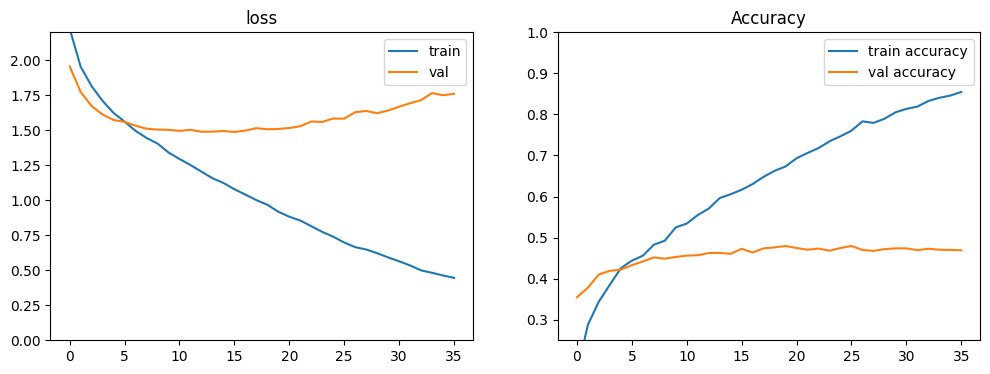

In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)

#### Testing ####

In [28]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [ ]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

images_np = np.stack(images_list)

In [35]:
X_eval = images_np

In [36]:
X_eval.shape

(4, 224, 224, 3)

In [37]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[1.8367482e-02 3.4370348e-02 7.5731561e-02 1.1987267e-02 1.8635788e-03
  5.6673598e-01 1.4204955e-01 1.9352816e-02 4.6602249e-02 8.2939133e-02]
 [8.2682657e-01 5.2462097e-02 1.9015908e-02 1.2140848e-03 6.6273795e-03
  7.7727665e-03 1.8979197e-03 4.2043170e-03 7.3437609e-02 6.5412540e-03]
 [6.0872780e-04 5.3917518e-04 2.0256666e-02 2.1833902e-02 4.3153682e-01
  9.6111903e-03 9.9268489e-02 3.8309929e-01 2.5793479e-03 3.0666325e-02]
 [3.9996332e-01 3.4524694e-03 3.7666913e-02 3.1839716e-03 6.3388061e-04
  5.6070596e-02 1.0517474e-02 8.8741109e-03 1.8564036e-01 2.9399690e-01]]


In [38]:
# indices
pred_indices = preds.argmax(axis=1)
# label
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Post-Impressionism', 'Abstract Expressionism', 'Neoclassicism',
       'Abstract Expressionism'], dtype=object)

In [39]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.57)
/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg : Abstract Expressionism (0.83)
/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Neoclassicism (0.43)
/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Abstract Expressionism (0.40)


### finetuning

In [32]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5

In [34]:
for layer in model.layers[100:132]:  # Excluding the layers we add ourself
    layer.trainable = True


In [35]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5

In [37]:
# Recompiler avec un learning rate plus petit
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_phase2 = model.fit(X_train, y_train_cat,
                           validation_split=0.3,
                           epochs=10,
                           callbacks=[es])

Epoch 1/10


E0000 00:00:1757085844.081370     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757085844.221762     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


154/154 ━━━━━━━━━━━━━━━━━━━━ 76s 343ms/step - accuracy: 0.4525 - loss: 1.5781 - val_accuracy: 0.4624 - val_loss: 1.5476
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.5406 - loss: 1.3434 - val_accuracy: 0.4714 - val_loss: 1.4828
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.5775 - loss: 1.2312 - val_accuracy: 0.4752 - val_loss: 1.4433
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.5957 - loss: 1.1489 - val_accuracy: 0.4771 - val_loss: 1.4301
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6300 - loss: 1.0521 - val_accuracy: 0.4805 - val_loss: 1.4197
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.6382 - loss: 1.0159 - val_accuracy: 0.4838 - val_loss: 1.4141
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.6745 - loss: 0.9501 - val_accuracy: 0.4881 - val_loss: 1.4163
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.6896 - loss: 0.8810 - val

In [38]:
model.save("/kaggle/working/model_Xception_firstimprovement_finetuned.keras")

In [39]:
model.evaluate(X_test, y_test_cat, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5302 - loss: 1.3732


{'accuracy': 0.5076666474342346, 'loss': 1.4063116312026978}

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

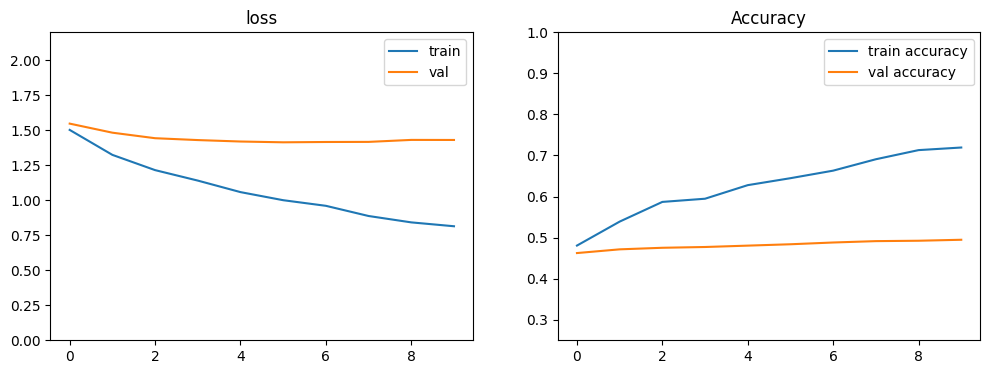

In [40]:
plot_history(history_phase2)

In [42]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [43]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

images_np = np.stack(images_list)

In [44]:
X_eval = images_np

In [45]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[4.5582248e-04 8.2590975e-02 3.6271434e-02 1.2052969e-02 4.6308871e-04
  8.1030083e-01 1.4494147e-02 2.6269536e-03 3.6065441e-02 4.6784421e-03]
 [9.6373546e-01 7.6585999e-03 1.7533937e-02 3.6212459e-04 1.0804436e-04
  1.6649726e-03 3.9426325e-04 1.1654594e-04 7.8482013e-03 5.7795231e-04]
 [3.6991005e-05 7.1455805e-05 1.6436309e-03 1.3750558e-02 3.1363195e-01
  1.2076535e-03 2.4788898e-01 4.0442440e-01 8.5936941e-04 1.6484896e-02]
 [5.8755234e-02 6.2968042e-03 1.6405812e-01 1.7351912e-02 1.0874280e-03
  1.7596820e-01 1.6428796e-03 5.4260081e-04 4.7724076e-02 5.2657276e-01]]


In [46]:
# indices
pred_indices = preds.argmax(axis=1)
# label
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Post-Impressionism', 'Abstract Expressionism', 'Romanticism',
       'Symbolism'], dtype=object)

In [47]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.81)
/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg : Abstract Expressionism (0.96)
/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Romanticism (0.40)
/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Symbolism (0.53)
